Preparation & Pathing Data

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("..").resolve()
DATASET_DIR = PROJECT_ROOT / "outputs" / "datasets"

FILES = {
    "ANOVA": {
        5: DATASET_DIR / "data5A.csv",
        7: DATASET_DIR / "data7A.csv",
        9: DATASET_DIR / "data9A.csv",
        10: DATASET_DIR / "data10A.csv",
    },
    "LASSO": {
        5: DATASET_DIR / "data5L.csv",
        7: DATASET_DIR / "data7L.csv",
        9: DATASET_DIR / "data9L.csv",
        10: DATASET_DIR / "data10L.csv",
    }
}

def load_topk(method: str, k: int):
    path = FILES[method][k]
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset file: {path}")
    df = pd.read_csv(path)

    if "Output" not in df.columns:
        raise ValueError(f"'Output' column not found in {path}. Columns: {df.columns.tolist()}")

    drop_cols = {"Output", "ClassName", "orig_path", "prep_path", "Path"} 
    feature_cols = [c for c in df.columns if c not in drop_cols]

    X = df[feature_cols].copy()
    y = df["Output"].astype(int).copy()
    return df, X, y, feature_cols, path


for m in ["ANOVA","LASSO"]:
    for k in [5,7,9,10]:
        _, X, y, feats, p = load_topk(m, k)
        print(m, k, "->", p.name, "| X:", X.shape, "| y:", y.shape, "| feats:", feats)


ANOVA 5 -> data5A.csv | X: (724, 5) | y: (724,) | feats: ['VAR', 'STD', 'ENT', 'CRL', 'CNT']
ANOVA 7 -> data7A.csv | X: (724, 7) | y: (724,) | feats: ['VAR', 'STD', 'ENT', 'CRL', 'CNT', 'HGN', 'IDM']
ANOVA 9 -> data9A.csv | X: (724, 9) | y: (724,) | feats: ['VAR', 'STD', 'ENT', 'CRL', 'CNT', 'HGN', 'IDM', 'KTS', 'SM']
ANOVA 10 -> data10A.csv | X: (724, 10) | y: (724,) | feats: ['VAR', 'STD', 'ENT', 'CRL', 'CNT', 'HGN', 'IDM', 'KTS', 'SM', 'RMS']
LASSO 5 -> data5L.csv | X: (724, 5) | y: (724,) | feats: ['CNT', 'STD', 'KTS', 'SM', 'SKEN']
LASSO 7 -> data7L.csv | X: (724, 7) | y: (724,) | feats: ['CNT', 'STD', 'KTS', 'SM', 'SKEN', 'ENT', 'VAR']
LASSO 9 -> data9L.csv | X: (724, 9) | y: (724,) | feats: ['CNT', 'STD', 'KTS', 'SM', 'SKEN', 'ENT', 'VAR', 'RMS', 'EG']
LASSO 10 -> data10L.csv | X: (724, 10) | y: (724,) | feats: ['CNT', 'STD', 'KTS', 'SM', 'SKEN', 'ENT', 'VAR', 'RMS', 'EG', 'CRL']


Train/Val/Test split (60/20/20, stratified)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42

def split_60_20_20(X, y, random_state=42):
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=random_state
    )
    X_val, X_te, y_val, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=random_state
    )
    return X_tr, X_val, X_te, y_tr, y_val, y_te

models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "SVM_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ])
}


Model Evaluate

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

def eval_one(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    acc = accuracy_score(y_te, pred)
    pm, rm, fm, _ = precision_recall_fscore_support(y_te, pred, average="macro", zero_division=0)
    pw, rw, fw, _ = precision_recall_fscore_support(y_te, pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_te, pred)
    return acc, pm, rm, fm, pw, rw, fw, cm

results = []

for method in ["ANOVA", "LASSO"]:
    for k in [5,7,9,10]:
        dfk, X, y, feat_cols, src = load_topk(method, k)
        X_tr, X_val, X_te, y_tr, y_val, y_te = split_60_20_20(X, y, random_state=RANDOM_STATE)

        for model_name, model in models.items():
            acc, pm, rm, fm, pw, rw, fw, cm = eval_one(model, X_tr, y_tr, X_te, y_te)

            results.append({
                "method": method,
                "k": k,
                "features": ",".join(feat_cols),
                "model": model_name,
                "accuracy": acc,
                "precision_macro": pm,
                "recall_macro": rm,
                "f1_macro": fm,
                "precision_weighted": pw,
                "recall_weighted": rw,
                "f1_weighted": fw,
                "confusion_matrix": cm.tolist(),
                "source_file": str(src)
            })

res_df = pd.DataFrame(results)
res_df.sort_values(["method","k","f1_macro"], ascending=[True, True, False]).head(20)


,method,k,features,model,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,confusion_matrix,source_file
3,ANOVA,5,"VAR,STD,ENT,CRL,CNT",AdaBoost,0.931034,0.895000,0.871940,0.882838,0.929517,0.931034,0.929998,"[[21, 6], [4, 114]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
5,ANOVA,5,"VAR,STD,ENT,CRL,CNT",SVM_RBF,0.924138,0.871490,0.881984,0.876596,0.925321,0.924138,0.924666,"[[22, 5], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
1,ANOVA,5,"VAR,STD,ENT,CRL,CNT",KNN,0.910345,0.841676,0.887790,0.861692,0.918822,0.910345,0.913173,"[[23, 4], [9, 109]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
0,ANOVA,5,"VAR,STD,ENT,CRL,CNT",LogReg,0.917241,0.870833,0.849184,0.859405,0.915287,0.917241,0.915998,"[[20, 7], [5, 113]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
4,ANOVA,5,"VAR,STD,ENT,CRL,CNT",RandomForest,0.910345,0.844928,0.873509,0.858068,0.914963,0.910345,0.912127,"[[22, 5], [8, 110]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
2,ANOVA,5,"VAR,STD,ENT,CRL,CNT",DecisionTree,0.903448,0.836207,0.854991,0.845085,0.906540,0.903448,0.904760,"[[21, 6], [8, 110]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
9,ANOVA,7,"VAR,STD,ENT,CRL,CNT,HGN,IDM",AdaBoost,0.931034,0.873939,0.914783,0.892241,0.936538,0.931034,0.932818,"[[24, 3], [7, 111]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
11,ANOVA,7,"VAR,STD,ENT,CRL,CNT,HGN,IDM",SVM_RBF,0.924138,0.871490,0.881984,0.876596,0.925321,0.924138,0.924666,"[[22, 5], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
10,ANOVA,7,"VAR,STD,ENT,CRL,CNT,HGN,IDM",RandomForest,0.917241,0.857759,0.877746,0.867216,0.919976,0.917241,0.918366,"[[22, 5], [7, 111]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
8,ANOVA,7,"VAR,STD,ENT,CRL,CNT,HGN,IDM",DecisionTree,0.917241,0.863465,0.863465,0.863465,0.917241,0.917241,0.917241,"[[21, 6], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...


Best Model per (Method K)

In [4]:
best_df = (
    res_df.sort_values("f1_macro", ascending=False)
          .groupby(["method","k"], as_index=False)
          .head(1)
          .sort_values(["method","k"])
)
best_df


,method,k,features,model,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,confusion_matrix,source_file
3,ANOVA,5,"VAR,STD,ENT,CRL,CNT",AdaBoost,0.931034,0.895000,0.871940,0.882838,0.929517,0.931034,0.929998,"[[21, 6], [4, 114]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
9,ANOVA,7,"VAR,STD,ENT,CRL,CNT,HGN,IDM",AdaBoost,0.931034,0.873939,0.914783,0.892241,0.936538,0.931034,0.932818,"[[24, 3], [7, 111]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
15,ANOVA,9,"VAR,STD,ENT,CRL,CNT,HGN,IDM,KTS,SM",AdaBoost,0.937931,0.881775,0.933302,0.904248,0.944864,0.937931,0.939889,"[[25, 2], [7, 111]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
21,ANOVA,10,"VAR,STD,ENT,CRL,CNT,HGN,IDM,KTS,SM,RMS",AdaBoost,0.931034,0.873939,0.914783,0.892241,0.936538,0.931034,0.932818,"[[24, 3], [7, 111]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
28,LASSO,5,"CNT,STD,KTS,SM,SKEN",RandomForest,0.931034,0.879310,0.900502,0.889347,0.933413,0.931034,0.931971,"[[23, 4], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
34,LASSO,7,"CNT,STD,KTS,SM,SKEN,ENT,VAR",RandomForest,0.931034,0.879310,0.900502,0.889347,0.933413,0.931034,0.931971,"[[23, 4], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
40,LASSO,9,"CNT,STD,KTS,SM,SKEN,ENT,VAR,RMS,EG",RandomForest,0.931034,0.879310,0.900502,0.889347,0.933413,0.931034,0.931971,"[[23, 4], [6, 112]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...
42,LASSO,10,"CNT,STD,KTS,SM,SKEN,ENT,VAR,RMS,EG,CRL",LogReg,0.931034,0.886221,0.886221,0.886221,0.931034,0.931034,0.931034,"[[22, 5], [5, 113]]",E:\Kuliah\Pengenalan Pola\addressing_agricultu...


Visualization

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import ast

OUT_DIR = PROJECT_ROOT / "outputs"
PLOT_DIR = OUT_DIR / "plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

def _cm_to_array(cm):
    if isinstance(cm, str):
        cm = ast.literal_eval(cm)
    return np.array(cm)

def savefig(fig, name):
    out = PLOT_DIR / name
    fig.savefig(out, bbox_inches="tight", dpi=150)
    print("Saved plot:", out)


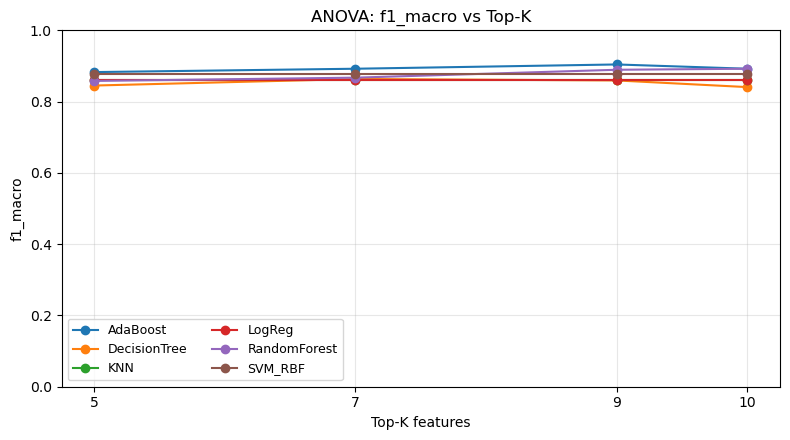

Saved plot: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\plots\anova_f1_macro_vs_k.png


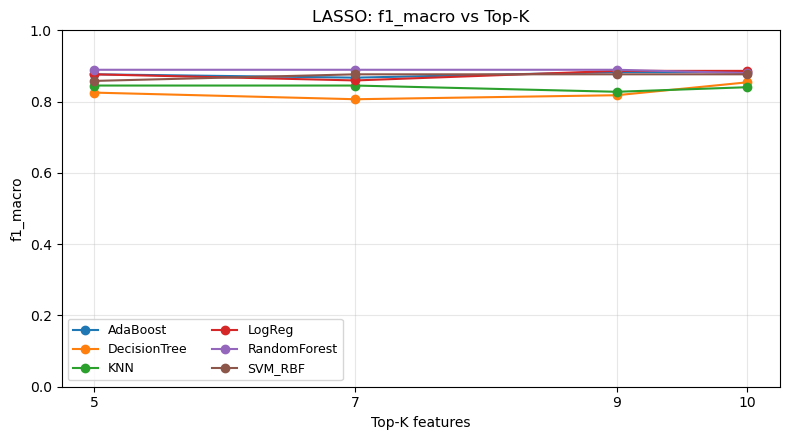

Saved plot: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\plots\lasso_f1_macro_vs_k.png


In [6]:
def plot_models_vs_k(res_df, method, metric="f1_macro", save=True):
    dfm = res_df[res_df["method"] == method].copy()
    Ks = sorted(dfm["k"].unique())

    fig, ax = plt.subplots(figsize=(8, 4.5))
    for model_name in sorted(dfm["model"].unique()):
        sub = dfm[dfm["model"] == model_name].sort_values("k")
        ax.plot(sub["k"], sub[metric], marker="o", label=model_name)

    ax.set_title(f"{method}: {metric} vs Top-K")
    ax.set_xlabel("Top-K features")
    ax.set_ylabel(metric)
    ax.set_xticks(Ks)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

    if save:
        savefig(fig, f"{method.lower()}_{metric}_vs_k.png")

plot_models_vs_k(res_df, "ANOVA", metric="f1_macro", save=True)
plot_models_vs_k(res_df, "LASSO", metric="f1_macro", save=True)


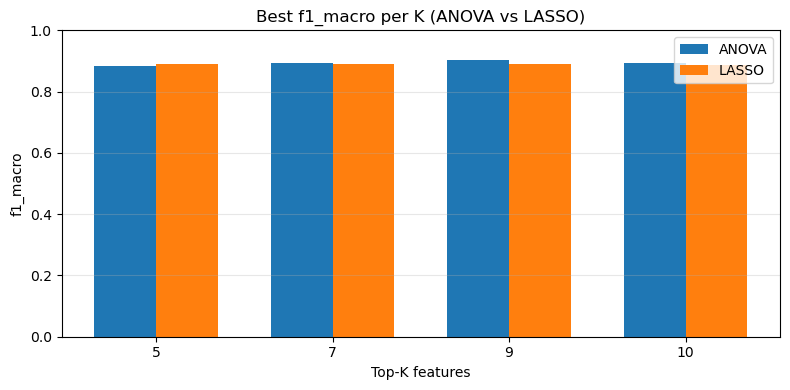

Saved plot: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\plots\best_f1_macro_anova_vs_lasso.png


In [7]:
def plot_best_per_k(best_df, metric="f1_macro", save=True):
    Ks = sorted(best_df["k"].unique())

    an = best_df[best_df["method"] == "ANOVA"].set_index("k")[metric].reindex(Ks)
    la = best_df[best_df["method"] == "LASSO"].set_index("k")[metric].reindex(Ks)

    x = np.arange(len(Ks))
    w = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - w/2, an.values, width=w, label="ANOVA")
    ax.bar(x + w/2, la.values, width=w, label="LASSO")

    ax.set_title(f"Best {metric} per K (ANOVA vs LASSO)")
    ax.set_xlabel("Top-K features")
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels([str(k) for k in Ks])
    ax.set_ylim(0, 1)
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    if save:
        savefig(fig, f"best_{metric}_anova_vs_lasso.png")

plot_best_per_k(best_df, metric="f1_macro", save=True)


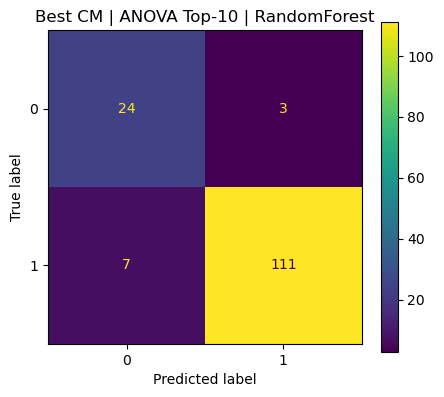

Best: ANOVA K= 10 | Model: RandomForest
F1-macro: 0.8922413793103448 | Acc: 0.9310344827586207
Features: VAR,STD,ENT,CRL,CNT,HGN,IDM,KTS,SM,RMS
Saved plot: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\plots\cm_best_anova_top10.png


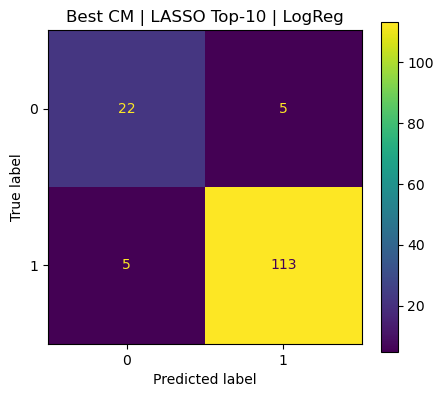

Best: LASSO K= 10 | Model: LogReg
F1-macro: 0.8862209667294413 | Acc: 0.9310344827586207
Features: CNT,STD,KTS,SM,SKEN,ENT,VAR,RMS,EG,CRL
Saved plot: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\plots\cm_best_lasso_top10.png


In [8]:
def plot_best_cm(res_df, method="ANOVA", k=10, save=True):
    dfk = res_df[(res_df["method"] == method) & (res_df["k"] == k)].copy()
    dfk = dfk.sort_values("f1_macro", ascending=False)
    row = dfk.iloc[0]

    cm = _cm_to_array(row["confusion_matrix"])
    model_name = row["model"]

    fig, ax = plt.subplots(figsize=(4.6, 4.0))
    disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f"Best CM | {method} Top-{k} | {model_name}")
    plt.tight_layout()
    plt.show()

    print("Best:", method, "K=", k, "| Model:", model_name)
    print("F1-macro:", row["f1_macro"], "| Acc:", row["accuracy"])
    print("Features:", row["features"])

    if save:
        savefig(fig, f"cm_best_{method.lower()}_top{k}.png")

plot_best_cm(res_df, method="ANOVA", k=10, save=True)
plot_best_cm(res_df, method="LASSO", k=10, save=True)
